Importing the dataset from server

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

DATASET_VERSION = 'mushroom_world_2017_16_10'
DATASET_LINK = 'https://s3.eu-central-1.amazonaws.com/deep-shrooms/{}.zip'.format(DATASET_VERSION)

with urlopen(DATASET_LINK) as zipresp:
    with ZipFile(BytesIO(zipresp.read())) as zfile:
        zfile.extractall('./data')


structuring the images and labels

In [ ]:
import pandas as pd
import numpy as np

DATASET_PATH = 'data/{}/'.format(DATASET_VERSION)

mushroom_classes = pd.read_json(DATASET_PATH + 'mushroom_classes.json', lines=True)
mushroom_imgs = pd.read_json(DATASET_PATH + 'mushroom_imgs.json', lines=True)
mushroom_info = mushroom_imgs.merge(mushroom_classes, how = "right", on = "name_latin")


Loading the images into dictionary

In [ ]:
import imageio

def load_mushroom_images(folder_path, img_df):
    img_dict = {}
    for index, path in enumerate(img_df['file_path']):
        img_dict[index] = imageio.imread(folder_path + path)
    return img_dict

img_dict = load_mushroom_images(DATASET_PATH, mushroom_info)

<ipython-input-4-fab69cad9858>:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_dict[index] = imageio.imread(folder_path + path)


In [ ]:
i = 0
for img in img_dict:
    if img_dict[img].shape != img_dict[0].shape:
        i = i + 1
        print(img_dict[img].shape)
        print(img)

#If this cell is run after the formatting is done, it should print 0 since all pictures should be in same format

(319, 480, 3)
10
(319, 480, 3)
11
(319, 480, 3)
12
(319, 480, 3)
13
(319, 480, 3)
14
(319, 480, 3)
17
(319, 480, 3)
18
(320, 480, 3)
55
(320, 480, 3)
56
(320, 480, 3)
57
(319, 480, 3)
58
(319, 480, 3)
59
(319, 480, 3)
60
(319, 480, 3)
105
(319, 480, 3)
106
(319, 480, 3)
107
(319, 480, 3)
108
(319, 480, 3)
112
(319, 480, 3)
113
(319, 480, 3)
114
(319, 480, 3)
115
(319, 480, 3)
116
(319, 480, 3)
120
(319, 480, 3)
121
(359, 480, 3)
148
(359, 480, 3)
155
(319, 480, 3)
159
(319, 480, 3)
160
(319, 480, 3)
161
(319, 480, 3)
162
(319, 480, 3)
172
(319, 480, 3)
173
(319, 480, 3)
174
(319, 480, 3)
175
(319, 480, 3)
176
(319, 480, 3)
177
(319, 480, 3)
178
(319, 480, 3)
179
(319, 480, 3)
180
(319, 480, 3)
189
(319, 480, 3)
190
(319, 480, 3)
191
(319, 480, 3)
192
(319, 480, 3)
193
(319, 480, 3)
194
(319, 480, 3)
195
(319, 480, 3)
196
(319, 480, 3)
197
(319, 480, 3)
198
(319, 480, 3)
199
(319, 480, 3)
211
(319, 480, 3)
215
(319, 480, 3)
231
(319, 480, 3)
232
(319, 480, 3)
233
(319, 480, 3)
234
(319,

Formatting the shape of image to a standard size of (480,480,3) required for training

In [31]:
import math
#Format the pictures to (480,480,3) by padding them with the edge values
for img in img_dict:
    height = 480 - img_dict[img].shape[0]
    width = 480 - img_dict[img].shape[1]

    if(height % 2 == 1 & width % 2 == 1):
        height1,height2 = math.floor(height/2), math.floor(height/2) + 1
        width1,width2 = math.floor(width/2), math.floor(width/2) +1
    elif(width % 2 == 1):
        width1,width2 = math.floor(width/2), math.floor(height/2) + 1
        height1,height2 = int(height/2), int(height/2)
    elif(height % 2 == 1):
        height1,height2 = math.floor(height/2), math.floor(height/2) + 1
        width1,width2 = int(width/2), int(width/2)
    else:
        height1,height2 = int(height/2), int(height/2)
        width1,width2 = int(width/2), int(width/2)

    if(height == 0):
        img_dict[img] = np.lib.pad(img_dict[img], ((0,0),(width1, width2),(0,0)), 'edge')
    elif (width == 0):
        img_dict[img] = np.lib.pad(img_dict[img], ((height1, height2),(0,0),(0,0)), 'edge')
    else:
        img_dict[img] = np.lib.pad(img_dict[img], ((height1, height2),(width1, width2),(0,0)), 'edge')

visualizing an image

In [ ]:
import matplotlib.pyplot as plt

def draw_im(i, image_data=img_dict, label_data=mushroom_info):
    name = label_data.iloc[i].name_latin
    edibility = label_data.iloc[i].edibility
    url = label_data.iloc[i].img_url
    x = image_data[i]
    plt.imshow(x)
    plt.title( name + ": " + edibility + "\n(" + url + ")")
    plt.show()


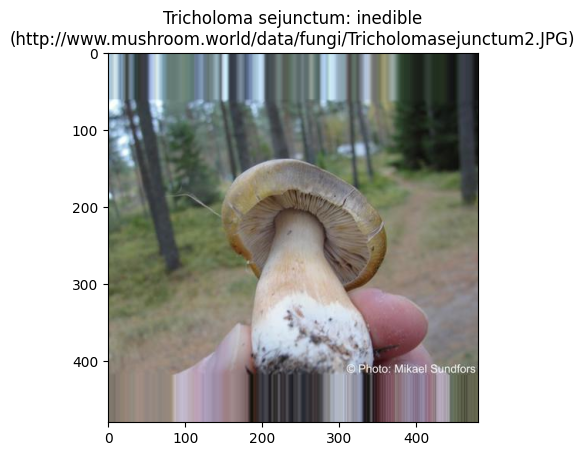

In [ ]:
draw_im(20)

converting multiple labels into binary labels

In [ ]:
mushroom_info.edibility.value_counts()

inedible                202
edible                  149
poisonous                77
edible and good          50
edible and excellent     27
lethally poisonous       16
edible when cooked       15
Name: edibility, dtype: int64

In [ ]:
labels = mushroom_info.edibility.isin(("edible", "edible and good", "edible and excellent"))

X = []
y = []

for i in range(len(labels)):
    if(img_dict[i].shape == (480,480,3)):
        y.append(labels[i])
        X.append(img_dict[i])


X = np.stack(X)
y = pd.Series(y)

print(X.shape)
print(y.shape)

(536, 480, 480, 3)
(536,)


In [ ]:
def draw_im2(i, X, y):
    plt.imshow(X[i])
    plt.title("edible: " + str(y[i]))
    plt.show()


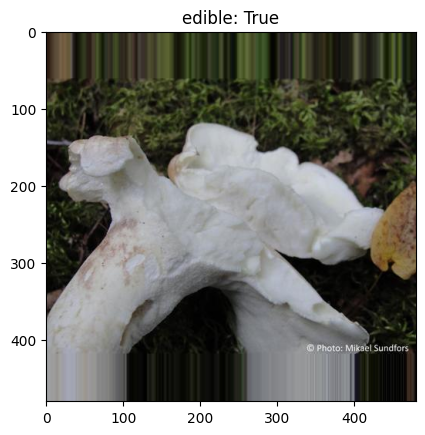

In [ ]:
draw_im2(2, X, y)

Augmentation of images

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator()


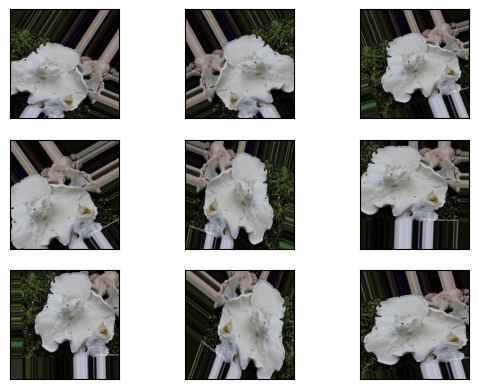

In [ ]:
# See how the augmentation looks like
x = X[1]
x = x.reshape((1,) + x.shape)

f, ax = plt.subplots(3, 3)
ax[0,0].imshow(x[0])

i = 0
for batch in train_datagen.flow(x, batch_size=1):
    img = batch.astype(np.uint8)
    fig = ax[int(i/3), i%3].imshow(img[0])
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    i += 1
    if i > 8:
        break  # otherwise the generator would loop indefinitely


plt.show()

Our labels are now a binary variable where "True" indicates that the mushroom is edible.

In [ ]:
y.value_counts()

False    310
True     226
dtype: int64

In [ ]:
# Train and test data

# rescale !!
X = X/255.0

N = len(X)
N_tr = int(0.8*N)

# shuffle the data
indx = np.arange(N)
np.random.shuffle(indx)
X = X[indx]
y = y[indx]

# split
X_tr = X[0:N_tr]
y_tr = y[0:N_tr]

X_te = X[N_tr:]
y_te = y[N_tr:]

Modeling

creating model architecture

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

def my_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=X[0].shape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('sigmoid')) # sigmoid is the binary case of softmax
    return model



In [ ]:
model = my_model()
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model_json = model.to_json()
with open("models/model.json", "w") as json_file:
    json_file.write(model_json)


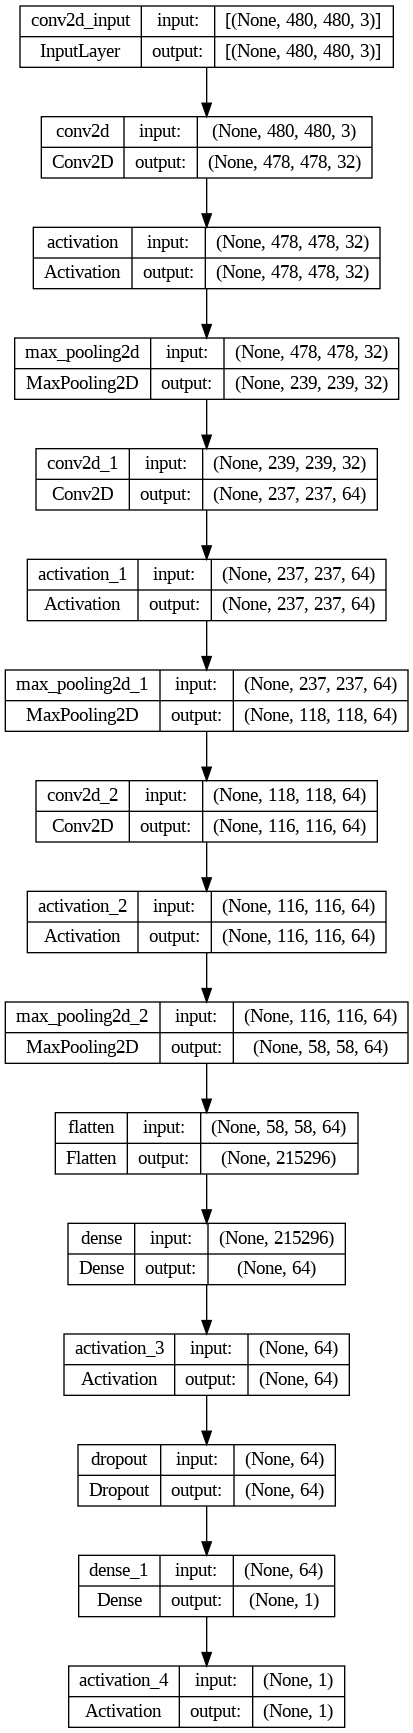

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes = True, to_file='docs/model.png')

training the model

In [20]:
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(train_datagen.flow(X_tr, y_tr, batch_size = 32),
                    validation_data = test_datagen.flow(X_te, y_te, batch_size = 32),
                    steps_per_epoch= len(X_tr) / 32,
                    validation_steps = len(X_te) /32,
                    epochs = 90, verbose = 1)

# save model weights and training history
model.save_weights('models/weights.h5')
model.save_weights('drive/MyDrive/weights.h5')
import pickle
with open('models/history', 'wb') as f:
        pickle.dump(history.history, f)

<ipython-input-20-03c931bdb683>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_datagen.flow(X_tr, y_tr, batch_size = 32),


Epoch 1/90
13/13 [==============================] - 276s 19s/step - loss: 2.5363 - accuracy: 0.5350 - val_loss: 1.9540 - val_accuracy: 0.5648
Epoch 2/90
13/13 [==============================] - 263s 19s/step - loss: 0.7479 - accuracy: 0.5327 - val_loss: 0.6906 - val_accuracy: 0.5648
Epoch 3/90
13/13 [==============================] - 254s 19s/step - loss: 0.6953 - accuracy: 0.5818 - val_loss: 0.6897 - val_accuracy: 0.5648
Epoch 4/90
13/13 [==============================] - 250s 19s/step - loss: 0.7186 - accuracy: 0.5421 - val_loss: 0.6921 - val_accuracy: 0.5648
Epoch 5/90
13/13 [==============================] - 257s 19s/step - loss: 0.7166 - accuracy: 0.5607 - val_loss: 0.6880 - val_accuracy: 0.5648
Epoch 6/90
13/13 [==============================] - 258s 19s/step - loss: 0.7125 - accuracy: 0.5841 - val_loss: 0.6891 - val_accuracy: 0.5648
Epoch 7/90
13/13 [==============================] - 257s 19s/step - loss: 0.6894 - accuracy: 0.5701 - val_loss: 0.6864 - val_accuracy: 0.5648
Epoch 

Visualizing training results

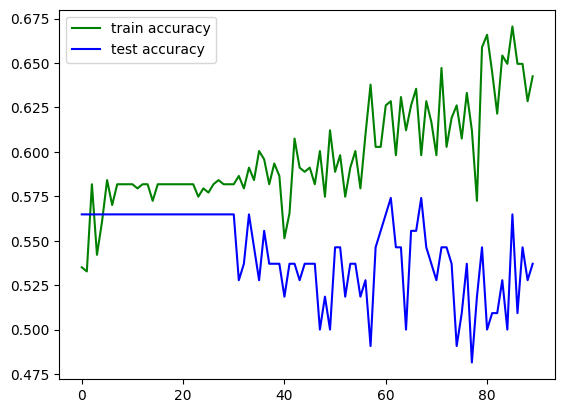

In [25]:
# load the model training history
with open("models/history", "rb") as f:
    hist = pickle.load(f)

plt.plot(hist["accuracy"], label = "train accuracy", color = "green")
plt.plot(hist["val_accuracy"], label = "test accuracy", color = "blue")
plt.legend()
plt.savefig("docs/training_history.png")
plt.show()

In [26]:
# load the saved json model
from keras.models import model_from_json

json_file = open('models/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("models/weights.h5")


Prediction using trained model

In [27]:
X_imgs = X*255.0

In [29]:
# inputs
# i: integer defining which image in X to do prediction on
# X: ndarray of shape (N, 480, 480 3) containing image data
# y: array of shape (N) containing edibility labels
# model: a model which has a .predict() method that outputs probabilities
# save: save the image to the docs/ folders
def predict_and_draw(i, X, y, model, save = False):
    x = X[i]
    x = x.astype(np.uint8)
    plt.imshow(x)
    x = x/ 255.0
    x.shape = (1, ) + x.shape
    p = model.predict(x)[0,0].round(2)
    plt.title("P(edible): " + str(p) + " Actually edible: " + str(y[i]))
    if(save):
        plt.savefig("docs/prediction_example.png")
    plt.show()


1/1 [==============================] - 0s 254ms/step


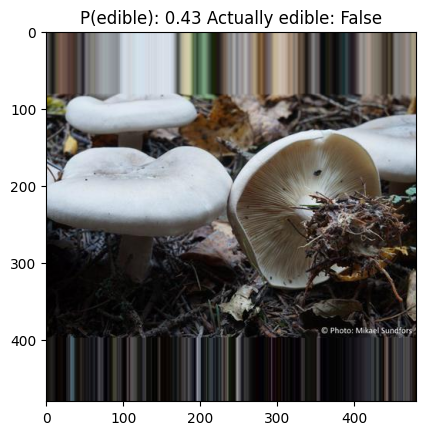

In [30]:
predict_and_draw(8, X = X_imgs, y = y, model = loaded_model, save = True)